In [2]:
%matplotlib inline
import msprime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import SVG

## Setting up a simple ABC inference scheme

The analytic challenges of deriving likelihood functions even under highly idealized models of population structure and history have led to the development of likelihood-free inference methods, in particular Approximate Bayesian Computation (ABC) (ref). ABC approximates the posterior distribution of model parameters by drawing from simulations. Because of its flexibility ABC has become a standard inference tool in statistical population genetics.

We will demonstrate how msprime can be used to set up an ABC inference by the way of a simple toy example. We stress that this is meant as an illustration rather than a inference tool for pratical use. However given the flexibility of msprime, we hope to that it should be relatively straighforward to implement more realistic framework. 

We assume that data for 100 loci or sequence blocks (these could be RAD loci in practice) for a single diploid individual have been generated from each of two populations. We would like to infer the amount of gene flow between the two populations. For the sake of simplicity we will assume the simplest possible model of population structure; that is two populations each of the same effective size that exchange migrants at a constant rate of M=4 N_e m migrants per generation. 

The function run_simulation simulates a dataset consisting of a specified number of loci (num_loci) given a migration rate m. We generate a single dataset of 100 loci assuming a migration rate m=0.3 (KL: we need to say that N_e is set to one by default), which we will use as a (pseudo)observed dataset in the ABC implementation.

In [40]:
nsamp = 2
population_configurations = [
    msprime.PopulationConfiguration(sample_size=nsamp),
    msprime.PopulationConfiguration(sample_size=nsamp)]
theta = 2

def run_sims(m, num_loci=1,theta=0):
    migration_matrix = [[0, m], [m, 0]]
    replicates = msprime.simulate(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        num_replicates=num_loci, 
        mutation_rate=theta/4)
    return replicates

def sum_seqData_SFS(reps):
    data = np.zeros((num_loci, nsamp+1, nsamp+1))
    for rep_index, ts in enumerate(reps):
        for tree in ts.trees(tracked_samples=[0, 1]):            
            for site in tree.sites():
                for mutation in site.mutations:                    
                    nleaves0 = tree.num_tracked_samples(mutation.node)
                    nleaves1 = tree.num_samples(mutation.node) - nleaves0                
                    data[rep_index, nleaves0, nleaves1] += 1            
    return data

num_loci = 100
true_m = 0.3
truth = sum_seqData_SFS(run_sims(true_m, num_loci=num_loci, theta=2))

run_simulation returns an iterator with the complete tree_sequence and mutational infromation of each locus. We use sum_seqData_SFS to summarize the polymorphism information as the joint site frequency spectrum (jSFS) of each locus, i.e. the blockwise site frequency spectrum bSFS (sensu Lohse et al 2016). Since msprime simulates rooted tree.sequences, the columns and rows of the unfolded jSFS correspond to the frequency of derived mutations in each population and the entries of the jSFS are simply mutation counts. E.g. for the first locus we have:

In [41]:
print("jSFS counts, first locus =")
print(truth[0])

jSFS counts, first locus =
[[ 0.  5.  1.]
 [ 6.  0.  3.]
 [ 0.  0.  0.]]


One could base inference on the bSFS (Beeravolou et al), but we will for the sake of simplicity use a simpler (and lossy) summary of the data: the average jSFS across loci. For analyses based on SNPs it is convient to normalize the jSFS by the total number of mutations:

In [76]:
truth_mean = np.mean(truth, axis=0)
truth_mean /=sum(sum(truth_mean))
print("mean jSFS =")
print(truth_mean)

mean jSFS =
[[ 0.          0.3222331   0.1136141 ]
 [ 0.22233105  0.043095    0.06366308]
 [ 0.12732615  0.10773751  0.        ]]


To illustrate a simple ABC inference scheme, we will focus on a single parameter of interest, the migration rate m.

We use the function run_simulation to simulate 10,000 datasets, each consisting of 100 genealogies and seeded by a random draw from the prior distribution of m. Below we assume an exponential distribution, a common choice of prior (ref Hey & Wakeley 2002). 

ABC measures the fit of data simulated under the prior to the observed data via a vector of summary statistics. We will use the jSFS as a summary statistic and approximate the jSFS from the length of genealogical branches (as in the bottleneck section above). Note that higher level population genetic summaries such as pairwise measures of divergence and diversity, F_st or D (ref) which are often used in ABC inference are just further (and lossy) summaries of the jSFS.

In [153]:
num_reps = 100
def approx_jSFS(reps):
    B = np.zeros((num_reps, nsamp+1, nsamp+1))
    for rep_index, ts in enumerate(reps):
        tree = next(ts.trees())
        samp1 = ts.samples(population_id=0)
        for tree in ts.trees(tracked_samples=samp1):
            for u in tree.nodes():
                nleaves1 = tree.num_tracked_samples(u)
                nleaves2 = tree.num_samples(u)-nleaves1
                if tree.parent(u) != msprime.NULL_NODE:
                    B[rep_index, nleaves1, nleaves2]+=tree.branch_length(u)
    data = np.mean(B, axis=0)
    data /=sum(sum(data))
    return data

num_prior_draws = 10000
prior_m = np.random.exponential(0.1, num_prior_draws)
prior_jSFS = np.zeros((num_prior_draws, nsamp+1, nsamp+1))
for j in range(num_prior_draws):
    prior_jSFS[j] = approx_jSFS(run_sims(prior_m[j], num_loci = num_reps))
print(prior_jSFS[0])

[[ 0.          0.14304856  0.26350693]
 [ 0.24694888  0.00992712  0.07325224]
 [ 0.23304951  0.03026676  0.        ]]


We compute the Euclidean distance between the observed jSFS and that of each simulated dataset:

In [159]:
distances = np.zeros(num_prior_draws)
for j in range(num_prior_draws):
    distances[j] = np.sqrt(np.sum((prior_jSFS[j] - truth_mean)**2))

In its simplest form, ABC approximates the posterior by sampling from the simulated data via an acceptance threshold: e.g. we can approximate the posterior distribution of m from the 5% of simulation replicates that most closely match the jSFS of the observed data. The posterior distribution (shown in orange) is centred around the truth m=0.3. (need to add axes labels for these x=m, y=posterior density)

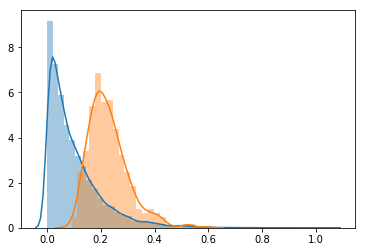

In [160]:
cutoff = np.percentile(distances, 5)
keep = np.where(distances < cutoff)
post_m=prior_m[keep]
sns.distplot(prior_m)
sns.distplot(post_m)

The mean and 95% approximate posterior credibility intervals for m are:

In [161]:
print([np.mean(post_m), [np.percentile(post_m,2.5),np.percentile(post_m,95.75)]])

[0.2297180008991368, [0.12624622465448088, 0.38942581765971174]]


## Cross-validation using pseudoobserved data sets

A question that commonly arises in the context of ABC is how much power/information we can expect about a particular parameter. A straightforward cross-validation procedure consists of repeating the inference on pseudoobserved data sets (PODS) generated under a known truth. Since we can use re-use the same set of simulation replicates for inference, this is computationally efficient. Here we generate 100 PODS (each consisting of 100 loci) for m=0.3:

In [157]:
num_loci = 100
num_pseudo_obs = 100
data_pseudo_obs = np.zeros((num_pseudo_obs, nsamp+1, nsamp+1))
for j in range(num_pseudo_obs):   
    data = sum_seqData_SFS(run_sims(true_m, num_loci=num_loci, theta=2))
    data_mean = np.mean(data, axis=0)
    data_pseudo_obs[j] = data_mean/sum(sum(data_mean))

We record the mean posterior estimate of m for each PODS: The mean of m estimates across PODS is close to the truth; the SD is 0.04. +/- 2SD gives a slightly narrower 95% posterior credibility interval than we obtained for the first replicate.

In [164]:
mean_ests = np.zeros(num_pseudo_obs)
for k in range(num_pseudo_obs):
    distances = np.zeros(num_prior_draws)
    for j in range(num_prior_draws):
        distances[j] = np.sqrt(np.sum((data_pseudo_obs[k]-prior_jSFS[j])**2))
    keep = np.where(distances < cutoff)
    mean_ests[k] = np.mean(prior_m[keep])

[0.26496537363377209, [0.17333817207577573, 0.35659257519176846]]


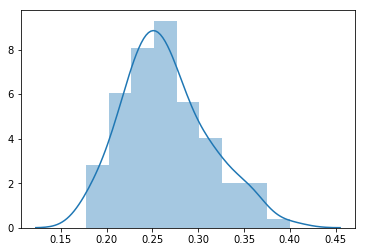

In [167]:
meanmPODS=np.mean(mean_ests)
SDmPODS=np.sqrt(np.var(mean_ests))
print([meanmPODS, [meanmPODS - 2*SDmPODS, meanmPODS + 2*SDmPODS]])
sns.distplot(mean_ests)

What effect does the acceptance threshold have on the inference? We compute the root-mean squared erro for a range of thresholds:

In [192]:
cutoffs = np.array([0.675,1.25,2.5,5,10,20])
len_c = len(cutoffs)
cutoff_range = [np.percentile(distances, i) for i in cutoffs]
post_means = [np.mean(prior_m[np.where(distances < i)]) for i in cutoff_range] 

mean_ests = np.zeros((len_c,num_pseudo_obs))
for i in range(len_c):          
    for k in range(num_pseudo_obs):
        distances = np.zeros(num_prior_draws)
        for j in range(num_prior_draws):
            distances[j] = np.sqrt(np.sum((data_pseudo_obs[k]-prior_jSFS[j])**2))
        cutoff=np.percentile(distances, cutoffs[i])
        keep = np.where(distances < cutoff)
        mean_ests[i][k] = np.mean(prior_m[keep])

In [204]:
mean_m = np.mean(mean_ests, axis=1)
mean_square_err = np.zeros((len_c,num_pseudo_obs))
for i in range(len_c):
    for k in range(num_pseudo_obs):
        mean_square_err[i][k] = (mean_ests[i][k] - true_m)**2
mean_square_err_fin =[np.sqrt(np.sum(mean_square_err[i])) for i in range(len_c)]
print(mean_m)
print(mean_square_err_fin)

[ 0.28748756  0.28429051  0.28032178  0.27353895  0.26054764  0.23641104]
[0.63037219572878278, 0.59256653517095448, 0.56639551296627111, 0.52886066623674166, 0.52639444532387503, 0.66186034964512297]


I think we want a plot of the mean and the root-mean_squared error (as defined above) against the acceptance threshold. This would show that posterior mean of m is increasingly biased (downwards) if we accept a larger sample from the posterior but that the error is very little affected by the acceptance threshold.

We also need to include axes labels on all plots and show the true m value (0.3 on the histogram above)...